<a href="https://colab.research.google.com/github/naomifridman/Introduction_to_deep_learning/blob/master/lstm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://github.com/nazmiasri95/LSTM-Keras-S-P500-data/blob/master/LSTM%20S%26P500.ipynb
import numpy as np
import pandas as pd
import re
import datetime as dt
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec
# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
from IPython.display import display, Markdown, Latex

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Seaborn for visualization
import seaborn as sns
#sns.set(font_scale = 2)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from pandas import read_csv, get_dummies
from matplotlib.pyplot import figure
from sklearn import svm


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split as split

import warnings
from sys import modules

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.metrics import mse, mae, mape
from keras import backend as K
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [1]:
!pip install quandl

     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 61kB 25.2MB/s 
     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 102kB 34.6MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=81a57a1db005b255038e85c269c9fa3d465b66cc2c2ef02bd71155ab0ccee81b
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7.2.0


In [2]:
import quandl
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

# Retrieve TSLA data from Quandl
tesla = quandl.get('WIKI/TSLA')

# Retrieve the GM data from Quandl
gm = quandl.get('WIKI/GM')
gm.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-11-18,35.00,35.99,33.89,34.19,457044300.0,0.0,1.0,29.988317,30.836558,29.037259,29.294302,457044300.0
2010-11-19,34.15,34.50,33.11,34.26,107842000.0,0.0,1.0,29.260029,29.559912,28.368948,29.354278,107842000.0
2010-11-22,34.20,34.48,33.81,34.08,36650600.0,0.0,1.0,29.302870,29.542776,28.968714,29.200053,36650600.0
2010-11-23,33.95,33.99,33.19,33.25,31170200.0,0.0,1.0,29.088668,29.122940,28.437493,28.488901,31170200.0
2010-11-24,33.73,33.80,33.22,33.48,26138000.0,0.0,1.0,28.900170,28.960146,28.463197,28.685967,26138000.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


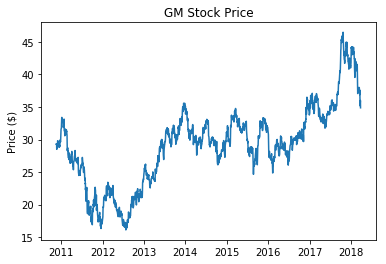

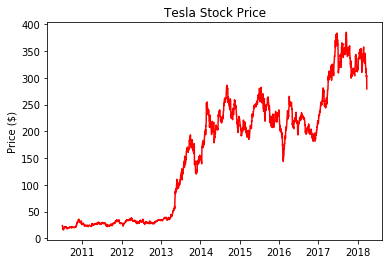

In [5]:
# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()

plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

### From here

In [7]:
from google.colab import files
uploaded = files.upload()


Saving sp500.csv to sp500.csv


In [0]:
df=pd.read_csv('sp500.csv')

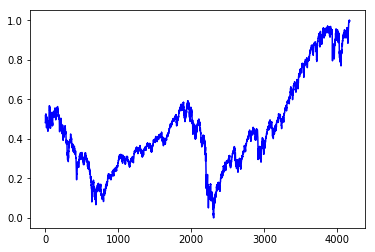

In [15]:
# Plot baseline and predictions
%matplotlib inline

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_dataset_norm = scaler.fit_transform(df)

plt.plot(close_dataset_norm, color='b')
plt.show()

In [0]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [0]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [0]:
# Hyperparameter
look_back = 10 # No of prev input used to predict next value
time_steps = 100 # No of time steps future prediction(s)
training_percent = 0.70

In [19]:
# Split into train and test sets (Training: 70%, Test: 30%)
train_size = int(len(close_dataset_norm) * training_percent)
test_size = len(close_dataset_norm) - train_size
train, test = close_dataset_norm[0:train_size,:], close_dataset_norm[train_size:len(close_dataset_norm),:]
print("Training datasets: ", len(train), ", Test datasets: ", len(test))
print("Training sets percentage (%):", float(training_percent)*100, ", Test sets percentage (%):", 100-float(training_percent)*100)

Training datasets:  2919 , Test datasets:  1251
Training sets percentage (%): 70.0 , Test sets percentage (%): 30.0


In [0]:
# Reshape into X=t and Y=t+loop_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## LSTM

In [26]:
# Create and fit the LSTM network
# Optimizers: sgd, rmsprop, adagrad, adadelta, adam, adamax, tfoptimizer, nadam
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back))) # , return_sequences=True
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae','mse','mape'])
model_history = model.fit(trainX, trainY, epochs=200, batch_size=100, verbose=1, 
                          validation_data=(testX,testY))

Train on 2908 samples, validate on 1240 samples
Epoch 1/200
2908/2908 [==============================] - 1s 346us/step - loss: 0.0230 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0230 - mean_absolute_percentage_error: 41370.4222 - val_loss: 8.8791e-04 - val_mean_absolute_error: 0.0248 - val_mean_squared_error: 8.8791e-04 - val_mean_absolute_percentage_error: 3.6617
Epoch 2/200
2908/2908 [==============================] - 0s 61us/step - loss: 0.0010 - mean_absolute_error: 0.0256 - mean_squared_error: 0.0010 - mean_absolute_percentage_error: 31945.2753 - val_loss: 0.0054 - val_mean_absolute_error: 0.0643 - val_mean_squared_error: 0.0054 - val_mean_absolute_percentage_error: 8.2698
Epoch 3/200
2908/2908 [==============================] - 0s 67us/step - loss: 7.2217e-04 - mean_absolute_error: 0.0204 - mean_squared_error: 7.2217e-04 - mean_absolute_percentage_error: 32155.8547 - val_loss: 0.0041 - val_mean_absolute_error: 0.0558 - val_mean_squared_error: 0.0041 - val_mean_absolute_

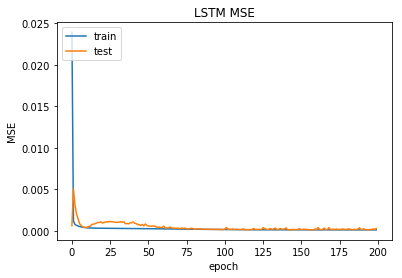

In [25]:
# summarize history for accuracy
plt.plot(model_history.history['mean_squared_error'])
plt.plot(model_history.history['val_mean_squared_error'])
plt.title('LSTM MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

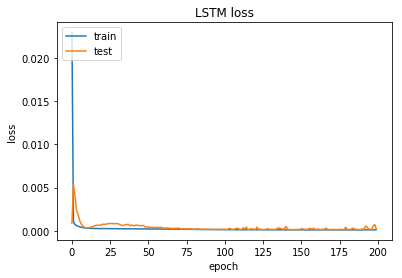

In [27]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(close_dataset_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [0]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(close_dataset_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close_dataset_norm)-1, :] = testPredict

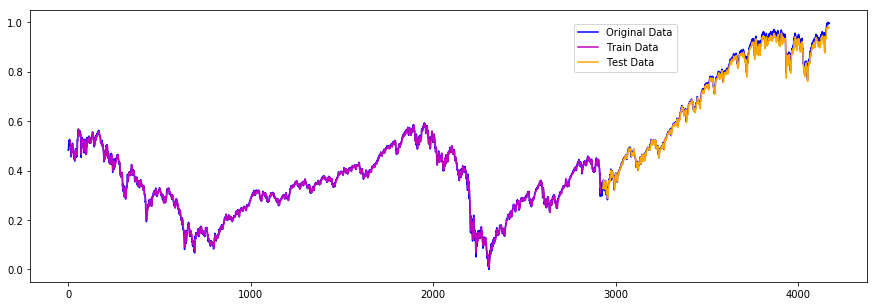

In [33]:
# Plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(close_dataset_norm, color='b', label='Original Data')
plt.plot(trainPredictPlot, color='m', label='Train Data')
plt.plot(testPredictPlot, color='orange', label='Test Data')
plt.legend(bbox_to_anchor=(0.65, 0.95), loc=2, borderaxespad=0.)
plt.show()

In [34]:
scores = model.evaluate(testX, testY, verbose=0)
lstm_mse = scores[2]

print("%s: %.4f" % (model.metrics_names[0], scores[0]))
print("%s: %.4f" % (model.metrics_names[1], scores[1]))
print("%s: %.4f" % (model.metrics_names[2], scores[2]))
print("%s: %.4f" % (model.metrics_names[3], scores[3]))

loss: 0.0002
mean_absolute_error: 0.0111
mean_squared_error: 0.0002
mean_absolute_percentage_error: 1.5763


In [35]:
from sklearn.metrics import mean_squared_error
print("MSE : %.4f" %(mean_squared_error(testY, testPredict)))

MSE : 0.0002


## Dense

In [0]:
trainX=trainX.reshape((2908, 10))

In [45]:
testX.shape

(1240, 10)

In [0]:
testX=testX.reshape((1240, 10))

In [61]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(16, kernel_initializer='normal',
                       input_dim = trainX.shape[1], activation='relu'))

NN_model.add(Dense(16, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))


# mean_squared_logarithmic_error
# mean_absolute_error
# mean_squared_error


# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', 
                 metrics=['mae','mse','mape'])
NN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 16)                176       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 16

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b16_rmsprop_net_264_512_512.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(trainX, trainY,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(testX, testY))

Train on 2908 samples, validate on 1240 samples
Epoch 1/200
2908/2908 [==============================] - 1s 301us/step - loss: 0.0162 - mean_absolute_error: 0.1022 - mean_squared_error: 0.0251 - mean_absolute_percentage_error: 13014.6741 - val_loss: 0.0011 - val_mean_absolute_error: 0.0517 - val_mean_squared_error: 0.0035 - val_mean_absolute_percentage_error: 6.7370

Epoch 00001: val_loss improved from inf to 0.00107, saving model to best_model_e200_b16_rmsprop_net_264_512_512.h5
Epoch 2/200
2908/2908 [==============================] - 0s 84us/step - loss: 2.0666e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 3.5236e-04 - mean_absolute_percentage_error: 13168.2917 - val_loss: 1.3626e-04 - val_mean_absolute_error: 0.0160 - val_mean_squared_error: 4.1604e-04 - val_mean_absolute_percentage_error: 2.3339

Epoch 00002: val_loss improved from 0.00107 to 0.00014, saving model to best_model_e200_b16_rmsprop_net_264_512_512.h5
Epoch 3/200
2908/2908 [==============================] - 0s

In [0]:
# Make predictions
trainPredict = NN_model.predict(trainX)
testPredict = NN_model.predict(testX)

In [0]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(close_dataset_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

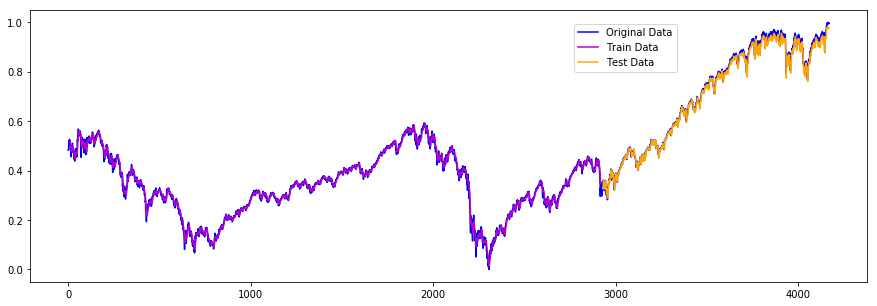

In [65]:
# Plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(close_dataset_norm, color='b', label='Original Data')
plt.plot(trainPredictPlot, color='m', label='Train Data')
plt.plot(testPredictPlot, color='orange', label='Test Data')
plt.legend(bbox_to_anchor=(0.65, 0.95), loc=2, borderaxespad=0.)
plt.show()

In [66]:
scores = NN_model.evaluate(testX, testY, verbose=0)
NN_model_mse = scores[2]

print("%s: %.4f" % (NN_model.metrics_names[0], scores[0]))
print("%s: %.4f" % (NN_model.metrics_names[1], scores[1]))
print("%s: %.4f" % (NN_model.metrics_names[2], scores[2]))
print("%s: %.4f" % (NN_model.metrics_names[3], scores[3]))

loss: 0.0001
mean_absolute_error: 0.0133
mean_squared_error: 0.0003
mean_absolute_percentage_error: 1.9220


In [67]:
from sklearn.metrics import mean_squared_error
print("MSE : %.4f" %(mean_squared_error(testY, testPredict)))

MSE : 0.0003
